# Finite Rank Derivations
This notebook contains the core functionality of our finite rank derivations algorithm with explanations. It also contains implementation of numerical experiments on spherical and circular vector fields.

## Dependencies

In [284]:
import numpy as np

#Used in Laplacian Eigenfunction Generation
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh

# Used in Visualization Tools
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt


## Core Functions
Functions which are core to the implementation of our technique.

### Laplacian Eigenfunction Generation
Core function for generating Laplacian Eigenvalues and Eigenvectors:

In [399]:
def gen_dm_laplacian_updated(X,eps,num_eigs): 
    """ 
    Given input sample data X and parameter eps, generate an rbf kernel matrix
    affinity. Perform diffusion maps and an eigendecomposition to return Laplacian Eigenfunctions.
    
    ----------
    X : array-like, shape = (dim, num_pts)
       Input sample data.

    eps : float
       Scaling Parameter
      
    num_eigs : int
       Number of eigenvalues to compute
       
    Returns
    ----------
     
    """
    (dim, num_pts) = X.shape
    
    euclidean_dist_sq = squareform(pdist(X.T))**2
    aff = np.exp(-euclidean_dist_sq / (eps**2))
    
    # For laplacian Eigenvalues, we use alph=1, but leaving this in in case we
    # someday are interested in taking weighted eigenvalues
    alph = 1
    
    d_negative_alpha = np.diag(np.sum(aff,axis=1) ** -alph)
                
    # normalize
    k_hat = d_negative_alpha @ aff @ d_negative_alpha
    
    d_hat_diag = np.sum(k_hat,axis=1)
    
    d_hat_negative_half = np.diag(d_hat_diag ** (-1/2))
    
    S = d_hat_negative_half @ k_hat @ d_hat_negative_half
    
    eigvals,eigvecs = eigh(S)

    #Renormalize eigenvalues so they correspond to Laplacian eigenvalues then sort
    eigvals = - np.log(eigvals) / (eps ** 2)
    
    #normalized with L^2 norm 1
    eigvecs_magnitudes = np.sqrt(np.sum(eigvecs ** 2,axis=0)/num_pts)
    eigvecs_normalized = eigvecs/eigvecs_magnitudes
    
    
    # Eigenvectors of S seem to give back a more accurate reconstruction
    # eigvecs = d_hat_negative_half @ eigvecs
    
    #Sort in ascending order
    eigvals = eigvals[::-1]
    eigvecs_normalized =np.flip(eigvecs_normalized,axis=1)
    
    #Return only num_eigs
    eigvals = eigvals[0:num_eigs]
    eigvecs_normalized = eigvecs_normalized[:,0:num_eigs]
    
    #Transpose them to make it more compatible with our code
    eigvecs_normalized = eigvecs_normalized.T
    
    return S,eigvals,eigvecs_normalized,aff

### Non Commutative Representation
Core functions for noncommutative representation / reconstruction:

In [400]:
def f_to_mult_op(f,basis,rank):
    
    '''
    Description
    -----------
    
    A function which transforms a vector representing values of a function f 
    on point cloud data into a finite-rank approximation of the 
    multiplication operator by f with respect to the input L^2 basis whose
    columns are approximate L^2 orthonormal basis functions. (Here we assume 
    that the L^2 inner product is weighted by the underlying sampling density.)
    
    Parameters
    ----------
    
    f : array-like, shape = num_pts,
        A vector whose entrees represent the values of  a function on input
        data.
    
    basis : array-like, shape = num_basis, num_pts
        An array whose columns are data-driven approximation to the first
        entrees L2 orthonormal basis of functions on the data set.
    
    rank : int, 
        The chosen rank of the output multiplication operator. Must be less 
        than the number of columns of eigvecs.
    
    -------
    f_op : array-like, shape = (rank, rank)
        An operator theoretic representation of the input function with 
        respect to the L^2 basis of functions approximated by the columns of
        basis. Such an operator takes in a vector of length rank whose entrees
        correspond to the L^2 coefficients of a function g with respect to the
        input basis.
    
    '''
    (num_basis, num_pts) = basis.shape
    
    # Check that the output rank is not greater than the number of input basis functions
    if num_basis < rank:
        print("The rank of multiplication operator exceeds the number of input basis functions.")
        return empty
    
    # Construct the multiplication operator corresponding to f
    m_f = np.zeros((rank,rank))
    for j in range(rank):
        for k in range(rank):
                m_f[j,k] = (1 / num_pts) * np.sum(f * basis[j,:] * basis[k,:])
    
    return m_f
        

def op_to_inner(op):
    
    '''
    Description
    -----------
    A helper function which maps finite-rank approximation of an operator to 
    an inner derivation. 
    
    Parameters
    ----------
    
    op : array-like, shape = rank, rank
        A finite rank operator 
    -------
    inner_op : function
        A function which takes in a square matrix of size rank and outputs the 
        commutator of op with the input matrix.
    '''
    
    def inner_op(A):
        return op @ A - A @ op
    
    return inner_op

def ker_to_sec(X, point, kernel=None):
    
    '''
    Description
    -----------
    Helper function which takes a kernel function together with sampled data X
    and specified point in X and outputs the kernel section corresponding to
    k(point,.) evaluated on the data set.
    
    Parameters
    ----------
    op : array-like, shape = (rank, rank)
        A matrix which represents a finite-rank approximation to a linear 
        operator acting on L^2 functions.
        
    kernel : function, kernel(x, y)
        A function which takes in two data points and outputs a positive
        real value. The kernel function is assumed to have exponential
        decay. That is: k(eps,x,y) < A * np.exp(-B*((x - y) @ (x - y))
        /(eps**2)) for some positive A, B.
    
    X : array-like, size = (dim, num_pts)
        An array whose columns correspond to point cloud data. Assumed to be 
        the underlying data set on which the approximate L2 basis functions 
        are computed.
    
    point : array-like, size = dim,
        A specific point for which the value of the operator is to be 
        reconstructed (assumed to be a point in the underlying data set X.)
        
    -------
    k_section : array-like, size = num_pts,
        Array whose entrees correspond to k(point, x_i) for each x_i in X.
    '''
    
    # The default kernel is an RBF kernel with pre-selected bandwidth parameter.    
    if kernel == None:
        eps = 0.1
        gaussian_kernel = lambda x,y : np.exp(-((x-y).T @ (x-y))/(eps**2))
        kernel = gaussian_kernel
        
    k_section = np.array([kernel(point,X[:,i]) for i in range(num_pts)])
    
    return k_section

def f_to_trunc(f,basis,rank):
    
    '''
    Description
    -----------
    Helper function which takes a function f represented as a vector of
    length num_pts and an array whose colums are approximate L^2 orthonormal
    basis of functions all with respect to some underlying data set X, outputs
    a vector of the first rank (input variable) coefficients of f with respect
    to the input basis.
    
    Parameters
    ----------
    
    f : array-like, shape = num_pts,
        A vector whose entrees represent the values of  a function on input
        data.
    
    basis : array-like, shape = num_basis, num_pts
        An array whose columns are data-driven approximation to the first
        entrees L2 orthonormal basis of functions on the data set.
    
    rank : int, 
        The chosen rank of the output multiplication operator. Must be less 
        than the number of columns of eigvecs.
    
    -------
    f_hat : array-like, shape = rank
        The first rank coefficients of f with respect to the input orthonormal basis.
    '''
    
    (num_basis, num_pts) = basis.shape
    
    # Check that the output rank is not greater than the number of input basis functions.
    if num_basis < rank:
        print("The rank of multiplication operator exceeds the number of input basis functions.")
        return empty
    
    # Construct a vector of the first rank fourier coefficients of f.
    f_hat = (1 / num_pts) * basis[0:rank,:] @ f
    
    return f_hat

def trunc_to_proj(f_hat,basis):
    
    '''
    Description
    -----------
    Helper function which takes a list of generalized fourier coefficients with
    respect to the provided finite approximate basis. Output is an operator
    which takes in a list of coefficients of the same size as f and output is
    the projection of the input onto f.
    
    Parameters
    ----------
    
    f_hat : array-like, shape = rank,
        A vector whose entrees represent the values of  a function on input
        data.
    
    basis : array-like, shape = num_basis, num_pts
        An array whose columns are data-driven approximation to the first
        entrees L2 orthonormal basis of functions on the data set.
    
    rank : int, 
        The chosen rank of the output multiplication operator. Must be less 
        than the number of columns of eigvecs.
    
    -------
    proj_f : array-like, shape = (rank,rank)
        The projection operator onto f_hat, which lives in the finite rank
        subspace spanned by the first rank basis functions.
    '''
    
    rank = f_hat.shape[0]
    
    proj_f = np.diag(f_hat)
    
    return proj_f
    
def op_ker_eval(op, X, point, basis, kernel=None):
    
    '''
    Description
    -----------
    A helper function combining the functions ker_to_sec and f_to_trunc. Takes in a kernel function and
    outputs a state corresponding to the input function f.
    
    Parameters
    ----------
    op : array-like, shape = (rank, rank)
        A matrix which represents a finite-rank approximation to a linear operator acting on L^2 functions.
        
    kernel : function, kernel(x, y)
        A function which takes in two data points and outputs a positive real value.
    
    X : array-like, size = (dim, num_pts)
        An array whose columns correspond to point cloud data. Assumed to be the underlying data set on which the approximate 
        L2 basis functions are computed.
    
    point : array-like, size = dim,
        A specific point for which the value of the operator is to be reconstructed (assumed to be a point in the underlying
        data set X.)
    
    -------
    op_x : A generalized pointwise evaluation at the given point.
    
    '''
    
    (rank,rank_check) = op.shape
    if rank_check != rank:
        print("The input operator is not square.")
        return empty
    
    k_sec = ker_to_sec(X,point,kernel)
    sq_k_sec = np.sqrt(k_sec)
    sq_k_sec_hat = f_to_trunc(sq_k_sec,basis,rank)
    
    # The vector must be normalized so that it is in fact a state.
    sq_k_sec_hat_mag = np.sqrt(sq_k_sec_hat @ sq_k_sec_hat)
    
    op_x = sq_k_sec_hat.T @ op @ sq_k_sec_hat
    
    return op_x

### Visualization Tools
Core functions for plotting, visualization, and vector field generation:

In [401]:
def generate_dataset(title, num_pts):
    ''' Generates experimental data, 'circle' and 'sphere' are uniformly sampled points on circle/sphere normalized 
    so that the circle/sphere has unit volume.'''
    
    np.random.seed(0)
    
    if title == 'sphere':
        dim = 3
        X = np.random.randn(dim,num_pts)
        # normalize so that manifold has unit volume (Trying to isolate sources of error)
        # Radius of ball
        X /= (3 / (4 * np.pi)) ** (-1 / 3) * np.linalg.norm(X,axis=0)

    if title == 'circle':
        dim = 2
        X = np.random.randn(dim,num_pts)
        # normalize so that manifold has unit volume (Trying to isolate sources of error)
        X /= (2 * np.pi) * np.linalg.norm(X,axis=0)
    return X

def spherical_grad(X,func):
    ''' Numerically approximates a vector field corresponding to the spherical
    gradient of func. Where func is a real valued python function on R^n'''
    
    dim,num_pts= X.shape
    gradient = np.zeros(X.shape)
    
    for i in range(num_pts):
        point = X[:,i]
        magnitude = np.sqrt(np.sum(point ** 2))
        unit_point = point / magnitude
        
        # numerically compute the gradient of func in R^3 in scipy
        jacobian = approx_fprime(point,func)
        
        # compute the component of the R^3 gradient in the normal direction
        extrinsic_deriv = (jacobian @ unit_point) * unit_point
    
        # compute the purely tangential part of the gradient by subtracting off normal
        cov_deriv = jacobian - extrinsic_deriv
        gradient[:,i] = cov_deriv
        
    return gradient

def plot_vf(X,v,input_scale=0.1):
    ''' Plots a 3d vector field. Inputs are two (3,num_pts) arrays corresponding
    to the basepoints (X) and vectors (v).'''
    
    dim, num_pts = X.shape
    margin_percent = 1.25
    
    plt.clf()
    if dim == 2:
        x_max = np.max(X[0,:])
        x_min = np.min(X[0,:])
        x_bound = margin_percent * np.max(np.abs([x_max,x_min]))
        
        y_max = np.max(X[1,:])
        y_min = np.min(X[1,:]) 
        y_bound = margin_percent * np.max(np.abs([y_max,y_min]))
        
        ax = plt.axes()
        ax.set_xlim(-x_bound, x_bound)
        ax.set_ylim(-y_bound, y_bound)

        
        x = X[0,:]
        y = X[1,:]
    
        a = v[0,:]
        b = v[1,:]
        
        ax.quiver(x,y,a,b,scale=input_scale)
        plt.show()
        
    if dim == 3:
        x_max = np.max(X[0,:])
        x_min = np.min(X[0,:])
        x_bound = margin_percent * np.max(np.abs([x_max,x_min]))
        
        y_max = np.max(X[1,:])
        y_min = np.min(X[1,:])
        y_bound = margin_percent * np.max(np.abs([y_max,y_min]))
        
        z_max = np.max(X[2,:])
        z_min = np.min(X[2,:]) 
        z_bound = margin_percent * np.max(np.abs([z_max,z_min]))
        
        ax = plt.axes(projection = '3d')
        ax.set_xlim3d(-x_bound,x_bound)
        ax.set_ylim3d(-y_bound,y_bound)
        ax.set_zlim3d(-z_bound,z_bound)
        
        x = X[0,:]
        y = X[1,:]
        z = X[2,:]
    
        a = v[0,:]
        b = v[1,:]
        c = v[2,:]
        ax.quiver(x,y,z,a,b,c,length=input_scale)
        plt.show()
        

## Experiment
We compare a vector field data set with an SEC reconstruction as well as a NC reconstruction.

### Generate test data:
Vector field on uniform sampled spherical or circular data:

In [402]:
num_pts = 1000

X = generate_dataset('circle',num_pts)
# X = generate_dataset('sphere',num_pts)

dim,num_pts = X.shape

def test_func(x):
    output = np.exp(x[0] ** 2 )
    return output

#SciPy tolerance parameter for numerical derivative approximation.

v = spherical_grad(X,test_func)

### Generate Laplacian Eigenfunctions
Compute approximate Laplacian eigenvalues and eigenvectors from the input data using Diffusion Maps algorithm.

In [403]:
eps = .1
num_eigs = 200

S, eigvals, basis, aff = gen_dm_laplacian_updated(X,eps,num_eigs)


C:\Users\vaugh\AppData\Local\Temp\ipykernel_24252\2499088621.py:52: RuntimeWarning: invalid value encountered in log
  eigvals = - np.log(eigvals) / (eps ** 2)


### Construct Operator Theoretic Representation
Represent the vector field in terms of its frame coefficients.

In [404]:
# number of eigenfunctions to use for SEC approximation
I = 30
J = 10
K = 5

# Convert eigvecs to be compatible with Yanbing's representation
eigvecs = basis.T

# %% Compute the Embedding Function Fourier Coefficients F_ak
F_ak_dm = (1 / num_pts) *  (X @ eigvecs[:,0:I])

# %% Generate Structure Coefficients c_ijk

# Helper function for generating c_ijk
def c_func_mc_dm(i, j, k, eigvecs):
    num_pts,num_eigs = eigvecs.shape
    return (1 / num_pts) * np.sum( eigvecs [:, i] * eigvecs [:, j] * eigvecs[:, k])

# Generate an array of all cijk's from i = 0 to i = I
c_mc_dm = [c_func_mc_dm(i, j, k, eigvecs[:,0:I]) for i in range(0, I)
           for j in range(0, I) 
           for k in range(0, I)]
            
c_mc_dm = np.reshape(np.array(c_mc_dm), (I, I, I ))

# %% Compute Riemannian Metric Coefficients g_ijk
# 
g_mc_dm = np.empty([I, I, I], dtype = float)
for i in range(0, I):
            for j in range(0, I):
                        for k in range(0, I):
                                    g_mc_dm[i,j,k] = (eigvals[i] + eigvals[j] - eigvals[k]) * c_mc_dm[i,j,k] / 2

# %% Compute Entrees of Gram Operator G_ijpq 

G_mc_dm = np.zeros([I, I, I, I], dtype = float)
G_mc_dm = np.einsum('ipm, jqm -> ijpq', c_mc_dm, g_mc_dm, dtype = float)

G_mc_dm = G_mc_dm[:J, :K, :J, :K]
G_mc_dm = np.reshape(G_mc_dm, (J*K, J*K))

# %% Compute The Dual Gram Operator G_dual_ijpq (using pseudoinverse)

# Threshold value for truncated SVD
threshold = 1/28
G_dual_mc_dm = np.linalg.pinv(G_mc_dm, rcond = threshold)

# L2 integral of products between eigenfunction phi_mn and "arrows" v_an
def monte_carlo_product_dm(eigvecs, v):
    dim,num_pts = X.shape
    integral = (1 / num_pts) * np.sum(eigvecs * v, axis = 1)
    
    return integral

# %% Compute b_am entries using (L2) deterministic Monte Carlo integral

def b_func_mc_dm(i):
    return monte_carlo_product_dm(eigvecs[:, i], v)

b_am_mc_dm =  [b_func_mc_dm(m) for m in range(I)]
b_am_mc_dm = np.array(b_am_mc_dm).T

# Apply analysis operator T to obtain v_hat_prime 
gamma_km_mc_dm = np.einsum('ak, am -> km', F_ak_dm, b_am_mc_dm, dtype = float)

g_mc_dm = g_mc_dm[:K, :, :]
eta_qlm_mc_dm = np.einsum('qkl, km -> qlm', g_mc_dm, gamma_km_mc_dm, dtype = float)

c_mc_dm = c_mc_dm[:J, :, :]
v_hat_prime_mc_dm = np.einsum('qlm, plm -> pq', eta_qlm_mc_dm, c_mc_dm, dtype = float)

v_hat_prime_mc_dm = np.reshape(np.array(v_hat_prime_mc_dm), (J*K,1))

# %%
# Apply dual Gram operator G^+ to obtain v_hat 
# Using pushforward vF and original vector field v
# Both with Monte Carlo integration with weights
v_hat_mc_dm = np.matmul(G_dual_mc_dm, v_hat_prime_mc_dm)
v_hat_mc_dm = np.reshape(v_hat_mc_dm, (J, K))

### SEC Reconstruction Method
Reconstruct the vector field using the SEC technique.

In [405]:

# %%
# Apply pushforward map F_* of embedding F to v_hat to obtain approximated vector fields
# Using Monte Carlo integration with weights

h_ajl_mc_dm = np.einsum('ak, jkl -> ajl', F_ak_dm, g_mc_dm, dtype = float)

d_jlm_mc_dm = np.einsum('ij, ilm -> jlm', v_hat_mc_dm, c_mc_dm, dtype = float)

p_am_mc_dm = np.einsum('ajl, jlm -> am', h_ajl_mc_dm, d_jlm_mc_dm, dtype = float)


pushforward = p_am_mc_dm @ (eigvecs[:,0:I].T)

### Non-Commutative Reconstruction Method
Reconstruct the vector field using the non-commutative technique.

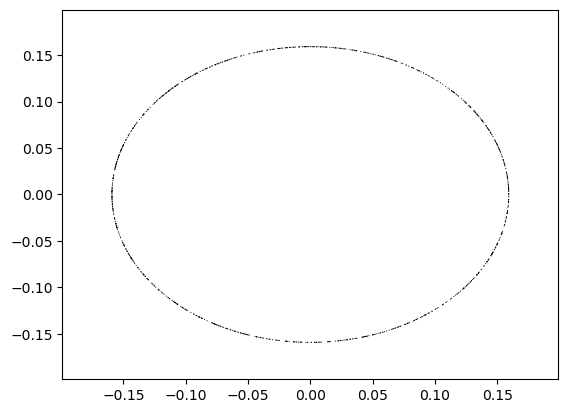

In [406]:
# reconstruction parameter
t = .001

# Set the minimum basis
rank = np.min((I,J,K))

# Truncate operator theoretic representation into square matrix
v_op = v_hat_mc_dm[0:rank,0:rank]

#Construct the inner derivation function corresponding to the vector field
v_inner = op_to_inner(v_op)


# Construct component functions used to identify the components of the given vector field
xs = [None for j in range(dim)]
for j in range(dim):
    xs[j] = X[j,:]
    
# Construct multiplication operators corresponding to component functions:
mxs = [None for j in range(dim)]
for j in range(dim):
    mxs[j] = f_to_mult_op(xs[j],basis,rank) 

# Input the multiplication operators into the inner derivation function 
vxs = [None for j in range(dim)]
for j in range(dim):
    vxs[j] = v_inner(mxs[j])

# Reconstruct the vector field entry by entry using the outputs of the function.
v_nc_re = np.zeros((dim,num_pts))
for i in range(num_pts):
    for j in range(dim):
        v_nc_reconstruct[j,i] = op_ker_eval(vxs[j], X, i, basis, kernel=None)


# Plot the vector field
plot_vf(X[:,0:1000],v_nc_reconstruct[:,0:1000])

# Debugging
## Issues:
- Noncommutative reconstruction is zeroing out the vector field
- Operator theoretic reconstruction (Conventional SEC) is off by a factor of ~4-5 when comparing maximum value of component functions of v.

## Pipeline:
1. Generate input data:
    1. data points
    2. example vector field
    3. RBF kernel with parameter epsilon
2. Generate approximate eigenfunctions:
    1. Diffusion Maps Algorithm
3. Generate SEC frame representation of vector field:
    1. Convert eigvecs to be compatible with Yanbing's representation
    2. Compute the Embedding Function Fourier Coefficients F_ak
    3. Generate Structure Coefficients c_ijk
    4. Generate an array of all cijk's from i = 0 to i = I
    5. Compute Riemannian Metric Coefficients g_ijk
    6. Compute Entrees of Gram Operator G_ijpq 
    7. Compute The Dual Gram Operator G_dual_ijpq (using pseudoinverse)
    8. Threshold value for truncated SVD
    9. L2 integral of products between eigenfunction phi_mn and "arrows" v_an
    10. Compute b_am entries using (L2) deterministic Monte Carlo integral
    11. Apply analysis operator T to obtain v_hat_prime 
4.Reconstruct the vector field using SEC:
    1. Apply dual Gram operator G^+ to obtain v_hat 
5. Reconstruct the data using Non-Commutative framework:
    1. Truncate operator theoretic representation into square matrix
    2. Construct component functions used to identify the components of the given vector field
    3. Construct multiplication operators corresponding to component functions
    4. Input the multiplication operators into the inner derivation function 
    5. Reconstruct the vector field entry by entry using the outputs of the function


# Checklist:
## Pipeline:
1. Generate approximate eigenfunctions:
    1. Diffusion Maps Algorithm
3. Generate SEC frame representation of vector field:
    1. Convert eigvecs to be compatible with Yanbing's representation
    2. Compute the Embedding Function Fourier Coefficients F_ak
    3. Generate Structure Coefficients c_ijk
    4. Generate an array of all cijk's from i = 0 to i = I
    5. Compute Riemannian Metric Coefficients g_ijk
    6. Compute Entrees of Gram Operator G_ijpq 
    7. Compute The Dual Gram Operator G_dual_ijpq (using pseudoinverse)
    8. Threshold value for truncated SVD
    9. L2 integral of products between eigenfunction phi_mn and "arrows" v_an
    10. Compute b_am entries using (L2) deterministic Monte Carlo integral
    11. Apply analysis operator T to obtain v_hat_prime 
4.Reconstruct the vector field using SEC:
    1. Apply dual Gram operator G^+ to obtain v_hat 
5. Reconstruct the data using Non-Commutative framework:
    1. Truncate operator theoretic representation into square matrix
    2. Construct component functions used to identify the components of the given vector field
    3. Construct multiplication operators corresponding to component functions
    4. Input the multiplication operators into the inner derivation function 
    5. Reconstruct the vector field entry by entry using the outputs of the function

## Checking Eigenvalues and Eigenvectors

C:\Users\vaugh\AppData\Local\Temp\ipykernel_24252\2673285963.py:25: RuntimeWarning: invalid value encountered in log
  eigvals = - np.log(eigvals) / (eps ** 2)


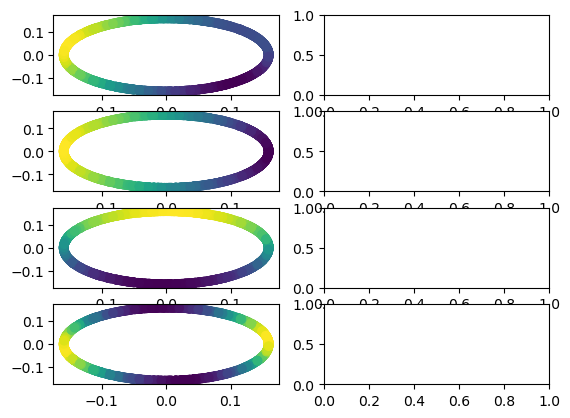

In [350]:
num_plot = 4
fig, axs = plt.subplots(num_plot, 2)

for i in range(num_plot):
    axs[i,0].scatter(X[0,:],X[1,:],c=basis[i,:])4
    axs[i,1].scatter(X[0,:],X[1,:],c =  

In [454]:
#REMOVE NORMALIZATION BY HAND
def gen_dm_laplacian_updated(X,eps,num_eigs): 
    """ 
    Given input sample data X and parameter eps, generate an rbf kernel matrix
    affinity. Perform diffusion maps and an eigendecomposition to return Laplacian Eigenfunctions.
    
    ----------
    X : array-like, shape = (dim, num_pts)
       Input sample data.

    eps : float
       Scaling Parameter
      
    num_eigs : int
       Number of eigenvalues to compute
       
    Returns
    ----------
     
    """
    (dim, num_pts) = X.shape
    
    euclidean_dist_sq = squareform(pdist(X.T))**2
    aff = np.exp(-euclidean_dist_sq / (eps**2))
    
    # For laplacian Eigenvalues, we use alph=1, but leaving this in in case we
    # someday are interested in taking weighted eigenvalues
    alph = 1
    
    d_negative_alpha = np.diag(np.sum(aff,axis=1) ** -alph)
                
    # normalize
    k_hat = d_negative_alpha @ aff @ d_negative_alpha
    
    d_hat_diag = np.sum(k_hat,axis=1)
    d_hat_negative_half = np.diag(d_hat_diag ** (-1/2))
    
    S = d_hat_negative_half @ k_hat @ d_hat_negative_half
    L_sym = np.eye(num_pts) - S
    eigvals,eigvecs = eigh(L_sym)
    
    eigvecs = d_hat_negative_half @ eigvecs
    
    #Return only num_eigs
    eigvals = eigvals[0:num_eigs]
    eigvecs = eigvecs[:,0:num_eigs]
    
    #Transpose them to make it more compatible with our code
    eigvecs = eigvecs.T
    return L_sym,eigvals,eigvecs,aff

eps = .1
num_eigs = 200

# rescale eigvecs so that magnitude is num_pts

L_sym, eigvals, basis, aff = gen_dm_laplacian_updated(X,eps,num_eigs)
